In [112]:
import stumpy
import pickle
import numpy as np
import sklearn.metrics as metrics

from pipelinetools import *

np.set_printoptions(suppress=True)
import seaborn as sns
import matplotlib.pyplot as plt
import tabulate

import bz2

In [2]:
with open('../results/data/X_comb', 'rb') as f:
    X = pickle.load(f)
    
with open('../results/data/X_pos', 'rb') as f:
    X_pos = pickle.load(f)
    
with open('../results/data/X_neg', 'rb') as f:
    X_neg = pickle.load(f)
    
with open('../results/data/ys', 'rb') as f:
    y = pickle.load(f)
    
with open('../results/data/test_pos', 'rb') as f:
    test_pos = pickle.load(f)
    
with open('../results/data/test_neg', 'rb') as f:
    test_neg = pickle.load(f)

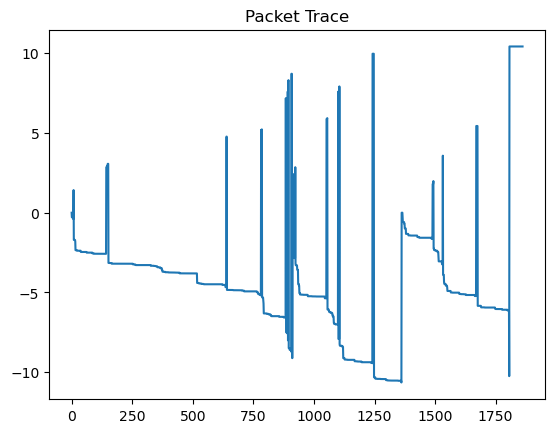

In [3]:
#sample_id = random.randint(0, 10000)
sample_id = 106

sample = X[sample_id]

plt.title("Packet Trace")
plt.plot(sample)

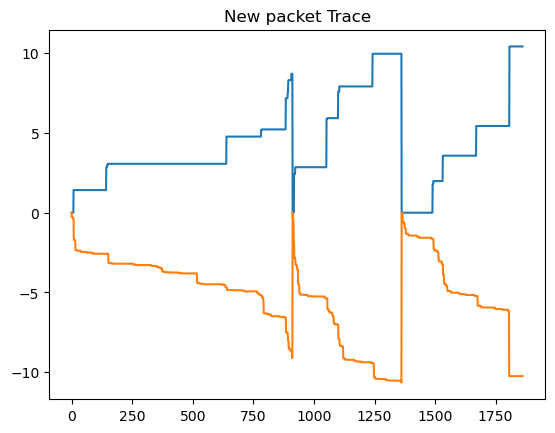

In [4]:
sample_pos = X_pos[sample_id]
sample_neg = X_neg[sample_id]

plt.title("New packet Trace")
plt.plot(sample_pos)
plt.plot(sample_neg)

In [5]:
print("True Class: " + str(y[sample_id]))
true_id = y[sample_id]
print("Dataset Sample ID: " + str(sample_id))
for i in range(1, len(sample_pos)):
    if sample_pos[i] < sample_pos[i-1]:
        true_idx = i
        break
print("True Match Index: " + str(true_idx))

True Class: 8
Dataset Sample ID: 106
True Match Index: 912


In [6]:
def euclid_align_dist(trace, sample, mode):
    distances = []
    
    for i in range(0, len(sample)-len(trace)):
        sample_slice = sample[i:i+len(trace)]
        moved_slice = []
        
        if mode == 'p':
            moved_slice = sample_slice - sample_slice[0]
        elif mode == 'n':
            moved_slice = sample_slice + abs(sample_slice[0])
        
        distance = np.linalg.norm(trace - moved_slice)
        distances.append(distance)
        
    return distances

In [7]:
def combo_distance(trace_pos, trace_neg, sample_pos, sample_neg, dist_func):
    
    if len(trace_pos) > len(sample_pos):
        raise ValueError
    
    pos_dist = dist_func(trace_pos, sample_pos, 'p')
    neg_dist = dist_func(trace_neg, sample_neg, 'n')
    combined_distance = [sum(x) for x in zip(pos_dist, neg_dist)]
    
    return np.asarray(combined_distance)

In [8]:
num_distances = len(test_pos[0])
distances = np.zeros( (len(test_pos.keys()), num_distances) )
matched_traces_pos = np.empty((num_distances, len(sample_pos)))
matched_traces_pos.fill(np.nan)
matched_traces_neg = np.empty((num_distances, len(sample_neg)))
matched_traces_neg.fill(np.nan)
matched_indices = np.zeros(num_distances)


class_id = true_id
for i in tqdm(range(num_distances)):
    trace_pos = test_pos[class_id][i]
    trace_neg = test_neg[class_id][i]
    
    
    try:
        dist = combo_distance(trace_pos, trace_neg, sample_pos, sample_neg, euclid_align_dist)
    except ValueError:
        print("Skipping Class " + str(class_id) + " (Trace Too Long)")
        break   
        
    distances[class_id][i] = min(dist)
    
    min_idx = np.argmin(dist)
    matched_indices[i] = min_idx
    
    start_point = sample_pos[min_idx]
    for j in range(len(trace_pos)):
        matched_traces_pos[i][min_idx + j] = trace_pos[j] + start_point
        
    start_point = sample_neg[min_idx]
    for j in range(len(trace_neg)):
        matched_traces_neg[i][min_idx + j] = trace_neg[j] - abs(start_point)
    

100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 56.88it/s]


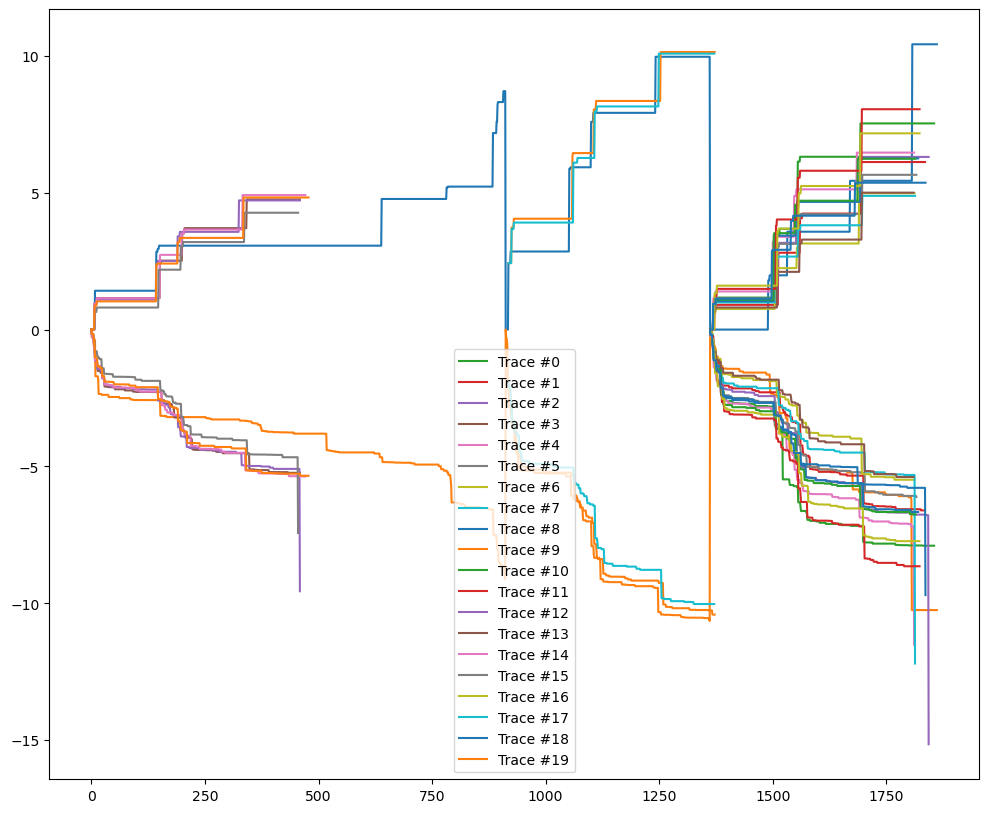

In [13]:
plt.figure(figsize=(12,10))

plt.plot(sample_pos)
plt.plot(sample_neg)

#plt.plot(matched_traces_neg[0])

for i in range(len(matched_traces_pos)):
    plt.plot(matched_traces_pos[i],label="Trace #" + str(i))
    plt.plot(matched_traces_neg[i], color=plt.gca().lines[-1].get_color())

plt.legend()

Best Match: 63.80449001516642


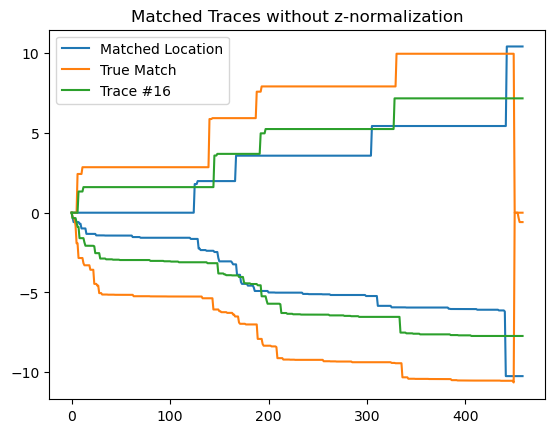

In [15]:
interest = 16
match_size = len(test_pos[true_id][interest])

match_idx = matched_indices[interest]
match_slice = slice(int(match_idx), int(match_idx + match_size))

true_slice = slice(true_idx, true_idx + match_size)

plt.plot(sample_pos[match_slice], label="Matched Location")
plt.plot(sample_neg[match_slice], color=plt.gca().lines[-1].get_color())

plt.plot(sample_pos[true_slice], label="True Match")
plt.plot(sample_neg[true_slice], color=plt.gca().lines[-1].get_color())

plt.plot(matched_traces_pos[interest][match_slice],label="Trace #" + str(interest))
plt.plot(matched_traces_neg[interest][match_slice], color=plt.gca().lines[-1].get_color())

plt.title("Matched Traces without z-normalization")

plt.legend()

print("Best Match: " + str(distances[true_id][interest]))

In [93]:
def calc_euclidean(trace_pos, trace_neg, sample_pos, sample_neg):
    pos_dist = np.linalg.norm(trace_pos-sample_pos)
    neg_dist = np.linalg.norm(trace_neg-sample_neg)
    
    return [round(pos_dist, 2), round(neg_dist, 2)]

In [94]:
def calc_mape(trace_pos, trace_neg, sample_pos, sample_neg):
    mape_pos = np.mean(np.nan_to_num(np.abs((trace_pos - sample_pos) / trace_pos), posinf=0, neginf=0))
    mape_neg = np.mean(np.nan_to_num(np.abs((trace_neg - sample_neg) / trace_neg), posinf=0, neginf=0))
    
    return [round(mape_pos, 2),round(mape_neg, 2)]

In [95]:
def calc_pearson(trace_pos, trace_neg, sample_pos, sample_neg):
    
    pos_pearson = pearson_helper(trace_pos, sample_pos)
    neg_pearson = pearson_helper(trace_neg, sample_neg)
    
    return [round(pos_pearson, 2), round(neg_pearson, 2)]

def pearson_helper(trace, sample):
    t_diff = trace - np.mean(trace)
    s_diff = sample - np.mean(sample)
    numerator = np.sum(t_diff * s_diff)
    denominator = np.sqrt(np.sum(t_diff ** 2)) * np.sqrt(np.sum(s_diff ** 2))
    return numerator / denominator

In [147]:
def calc_cbd(trace_pos, trace_neg, sample_pos, sample_neg):
    
    pos_cbd = cbd_helper(trace_pos, sample_pos)
    neg_cbd = cbd_helper(abs(trace_neg), abs(sample_neg))
    
    return [round(pos_cbd, 2), round(neg_cbd, 2)]

def cbd_helper(trace, sample, n_letters=10):
    
    t_bins = sax_bins(trace, n_letters)
    s_bins = sax_bins(sample, n_letters)
    
    t_letters = sax_transform(trace, t_bins)
    s_letters = sax_transform(sample, s_bins)
    
    len_t = len(bz2.compress(t_letters))
    len_s = len(bz2.compress(s_letters))
    len_combined = len(bz2.compress(t_letters + s_letters))
    return len_combined / (len_t + len_s)

def sax_bins(packets, n_letters):
    
    bins = np.percentile(
        packets[packets != 0],
        np.linspace(0, 100, n_letters + 1)
    )
    bins[0] = 0
    bins[-1] = 1e1000
    return bins

def sax_transform(packets, bins):
    
    indices = np.digitize(packets, bins) - 1
    alphabet = np.array([*("abcdefghijklmnopqrstuvwxyz"[:len(bins) - 1])])
    text = "".join(alphabet[indices])
    return str.encode(text)

In [154]:
interest_pos = matched_traces_pos[interest][match_slice]
interest_neg = matched_traces_neg[interest][match_slice]

true_pos = sample_pos[true_slice]
true_neg = sample_neg[true_slice]

match_pos = sample_pos[match_slice]
match_neg = sample_neg[match_slice]

distance_table = []

distance_table.append([
    "Euclidean",
    calc_euclidean(interest_pos, interest_neg, match_pos, match_neg),
    calc_euclidean(interest_pos, interest_neg, true_pos, true_neg),
    "[0, inf)"
])

distance_table.append([
    "MAPE",
    calc_mape(interest_pos, interest_neg, match_pos, match_neg),
    calc_mape(interest_pos, interest_neg, true_pos, true_neg),
    "[0,1]"
])

distance_table.append([
    "Pearson Coeff",
    calc_pearson(interest_pos, interest_neg, match_pos, match_neg),
    calc_pearson(interest_pos, interest_neg, true_pos, true_neg),
    "[-1, 1]"
])

distance_table.append([
    "CBD",
    calc_cbd(interest_pos, interest_neg, match_pos, match_neg),
    calc_cbd(interest_pos, interest_neg, true_pos, true_neg)
])

/var/folders/ww/7kn8t7y91gv3dzhg4tzjhq4m0000gn/T/ipykernel_92168/2142677916.py:2: RuntimeWarning: invalid value encountered in true_divide
  mape_pos = np.mean(np.nan_to_num(np.abs((trace_pos - sample_pos) / trace_pos), posinf=0, neginf=0))
/var/folders/ww/7kn8t7y91gv3dzhg4tzjhq4m0000gn/T/ipykernel_92168/2142677916.py:3: RuntimeWarning: invalid value encountered in true_divide
  mape_neg = np.mean(np.nan_to_num(np.abs((trace_neg - sample_neg) / trace_neg), posinf=0, neginf=0))
/var/folders/ww/7kn8t7y91gv3dzhg4tzjhq4m0000gn/T/ipykernel_92168/2142677916.py:2: RuntimeWarning: divide by zero encountered in true_divide
  mape_pos = np.mean(np.nan_to_num(np.abs((trace_pos - sample_pos) / trace_pos), posinf=0, neginf=0))


In [155]:
tabulate.tabulate(distance_table, headers=["Matched Distance [Pos, Neg]", 'True Distance [Pos, Neg]', 'Range of Outputs'], tablefmt='html')

,"Matched Distance [Pos, Neg]","True Distance [Pos, Neg]",Range of Outputs
Euclidean,"[34.64, 29.17]","[54.42, 59.42]","[0, inf)"
MAPE,"[0.45, 0.27]","[0.6, 0.55]","[0,1]"
Pearson Coeff,"[0.9, 0.92]","[0.88, 0.83]","[-1, 1]"
CBD,"[0.62, 0.63]","[0.57, 0.64]",


In [198]:
def cbd_dist(trace_pos, trace_neg, sample_pos, sample_neg):
    distances = []
    
    for i in range(0, len(sample_pos)-len(trace_pos)):
        sample_slice = slice(i, i + len(trace_pos))
        
        distance = calc_cbd(trace_pos, trace_neg, sample_pos[sample_slice], sample_neg[sample_slice])
        distances.append(min(distance))
        
    return distances

In [239]:
num_distances = len(test_pos[0])
distances = np.zeros( (len(test_pos.keys()), num_distances) )
matched_traces_pos = np.empty((num_distances, len(sample_pos)))
matched_traces_pos.fill(np.nan)
matched_traces_neg = np.empty((num_distances, len(sample_neg)))
matched_traces_neg.fill(np.nan)
matched_indices = np.zeros(num_distances)


class_id = true_id
for i in tqdm(range(num_distances)):
    trace_pos = test_pos[class_id][i]
    trace_neg = test_neg[class_id][i]
    
    dist = cbd_dist(trace_pos, trace_neg, sample_pos, sample_neg)
        
    distances[class_id][i] = min(dist)
    
    min_idx = np.argmin(dist)
    matched_indices[i] = min_idx
    
    start_point = sample_pos[min_idx]
    for j in range(len(trace_pos)):
        matched_traces_pos[i][min_idx + j] = trace_pos[j]
        
    start_point = sample_neg[min_idx]
    for j in range(len(trace_neg)):
        matched_traces_neg[i][min_idx + j] = trace_neg[j]
    

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:25<00:00,  1.28s/it]


In [240]:
print("Distances" + str(distances[class_id]))

Distances[0.6  0.59 0.6  0.56 0.55 0.56 0.58 0.57 0.57 0.56 0.56 0.57 0.57 0.58
 0.59 0.58 0.56 0.57 0.58 0.58]


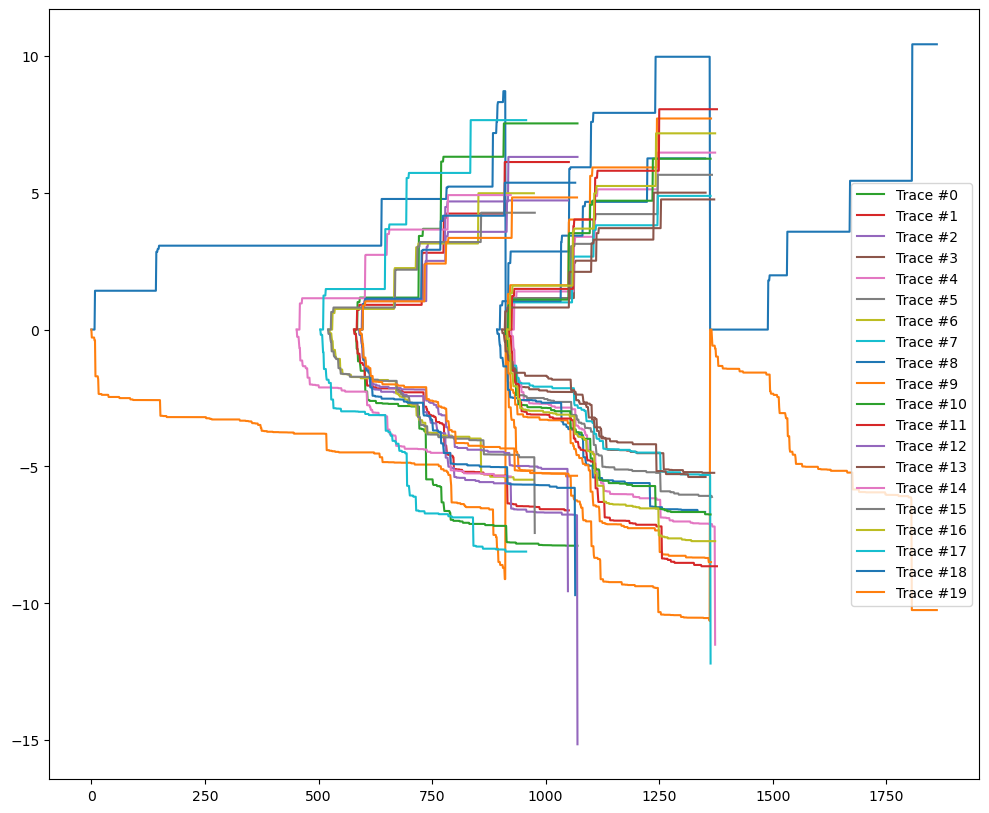

In [241]:
plt.figure(figsize=(12,10))

plt.plot(sample_pos)
plt.plot(sample_neg)

#plt.plot(matched_traces_neg[0])

for i in range(len(matched_traces_pos)):
    plt.plot(matched_traces_pos[i],label="Trace #" + str(i))
    plt.plot(matched_traces_neg[i], color=plt.gca().lines[-1].get_color())

plt.legend()

Matched Distance: 0.55


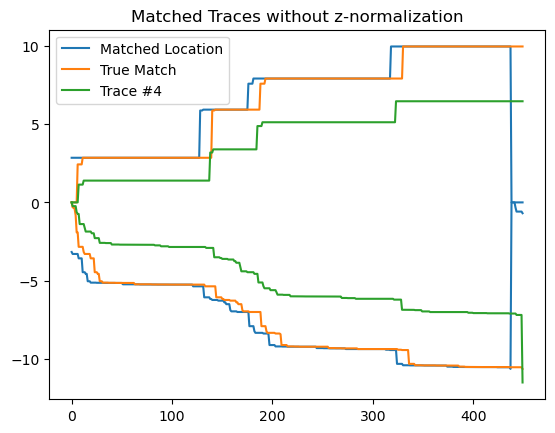

In [242]:
interest = 4
match_size = len(test_pos[class_id][interest])

match_idx = matched_indices[interest]
match_slice = slice(int(match_idx), int(match_idx + match_size))

true_slice = slice(true_idx, true_idx + match_size)

plt.plot(sample_pos[match_slice], label="Matched Location")
plt.plot(sample_neg[match_slice], color=plt.gca().lines[-1].get_color())

plt.plot(sample_pos[true_slice], label="True Match")
plt.plot(sample_neg[true_slice], color=plt.gca().lines[-1].get_color())

plt.plot(test_pos[class_id][interest],label="Trace #" + str(interest))
plt.plot(test_neg[class_id][interest], color=plt.gca().lines[-1].get_color())

plt.title("Matched Traces without z-normalization")

plt.legend()

print("Matched Distance: " + str(distances[class_id][interest]))

In [12]:
def z_normalize(x):
    mean = np.mean(x)
    std = np.std(x)
    new_x = x - mean
    new_x /= std
    return new_x

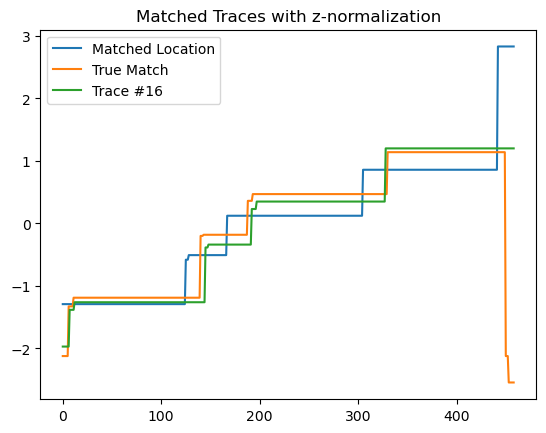

In [13]:
interest = 16
match_size = len(test_pos[true_id][interest])

match_idx = matched_indices[interest]
match_slice = slice(int(match_idx), int(match_idx + match_size))

true_slice = slice(true_idx, true_idx + match_size)

plt.plot(z_normalize(sample_pos[match_slice]), label="Matched Location")
#plt.plot(z_normalize(sample_neg[match_slice]), color=plt.gca().lines[-1].get_color())

plt.plot(z_normalize(sample_pos[true_slice]), label="True Match")
#plt.plot(z_normalize(sample_neg[true_slice]), color=plt.gca().lines[-1].get_color())

plt.plot(z_normalize(matched_traces_pos[interest][match_slice]),label="Trace #" + str(interest))
#plt.plot(z_normalize(matched_traces_neg[interest][match_slice]), color=plt.gca().lines[-1].get_color())

plt.title("Matched Traces with z-normalization")

plt.legend()